# Thom Ives
2357 W Burns St, Eagle, ID 83616

[My LinkedIn Profile](https://www.linkedin.com/in/thomives)
[My Blog](https://integratedmlai.com)
[My GitHub](https://www.github.com/thomives)

## Assigned Problem
Regression or Classification
Provide a Description of the Results
 
Description
1. Each one of these instances represents one job. 
2. We have to run the jobs on a set of servers, and run multiple jobs per server. 
3. It is costly and slow to directly measure the memory usage of a job, so we can’t do that for every job. 
4. This is a small sample of jobs, hopefully chosen to give a good sampling of both size and the other metrics. 
5. If we can reliably predict the memory size, we can make more efficient use of our servers.

Here’s the problem:
1. Can we reliably predict the first column (memory size in bytes--hard to get) from the remaining columns (which are easy to get)?
2. Are the results usable or unusable?
3. If they are usable, how would you communicate your findings to software developers? 
4. What would it take (artifacts, techniques, libraries) to get them into a real system?
5. If they are unusable, could you explain why?
 
## My Work
Present your own data science project that you have been working on. 
This should be a project that isn’t one of the common projects that can be found online. 
Feel free to use whatever delivery tool you would like (e.g. PowerPoint, jupyter notebook).

## Import Area

In [7]:
import pandas as pd
import numpy as np
import numpy.random as nr
import math

import scipy.stats as ss
import statsmodels.api as sm
import sklearn.model_selection as ms
import sklearn.metrics as sklm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor as rfr
from xgboost import XGBRegressor as xgr
from sklearn.ensemble import AdaBoostRegressor as abr
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime

pd.options.mode.chained_assignment = None # Because I get tired of pandas warnings after a while ...

## Useful Functions

In [2]:
def get_NaN_density(df):
    """ 
    The first sum gives a sum by column. 
    The second sum sums the column sums to give a total sum for the dataframe.
    The density is the number of cells with NaN's divided by the total number of dataframe cells.
    """
    NaN_density = df.isnull().sum().sum() / (len(df.columns) * len(df))
    
    return NaN_density

def apply_one_hot_encoding_for_array_of_columns(X, col_array):
    col_array.sort(reverse=True)
    
    for col_num in col_array:
        col = X[:,col_num]
        labels = np.unique(col)
        ohe = OneHotEncoder(categories=[labels])
        tmp = ohe.fit_transform(col.reshape(-1, 1)).toarray()
        X = np.concatenate((X[:,:col_num], tmp[:,:-1], X[:,col_num+1:]), axis=1)
    
    return X

def correlation_matrix(df, title):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 20) # 30
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title(title + '\nLabel and Features Correlation Map', fontsize=18)
    labels=df.columns.tolist()
    ax1.set_xticklabels(labels,fontsize=12, rotation='vertical')
    ax1.set_yticklabels(labels,fontsize=12)
    ax1.set_xticks(np.arange(len(labels)))
    ax1.set_yticks(np.arange(len(labels)))
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    tick_array = [float(x) / 20.0 for x in range(-20,21,1)]
    fig.colorbar(cax, ticks=tick_array)
    plt.show()

In [3]:
def get_regression_model(algo, settings, print_mod_info=False):
    ### Regression models
    ### https://stackoverflow.com/questions/12860841/python-import-in-if
    if   algo == 'XGR': 
        mod = xgr(n_estimators = settings[0], max_depth=settings[1])
        if print_mod_info: print('XGBoost:', mod)
    elif algo == 'RFR': 
        mod = rfr(n_estimators = settings[0])
        if print_mod_info: print('Random Forest:', mod)
    elif algo == 'ABR':
        print(settings)
        mod = abr(n_estimators = settings[0])
        if print_mod_info: print('AdaBoost:', mod)
    elif algo == 'P1R': 
        mod = LinearRegression()
        if print_mod_info: print('Linear:', mod)
    elif algo == 'RDG': 
        mod = Ridge()
        if print_mod_info: print('Ridge:', mod)
    elif algo == 'LSS': 
        mod = Lasso()
        if print_mod_info: print('Ridge:', mod)
    elif algo == 'P2R': 
        mod = make_pipeline(PolynomialFeatures(settings[0]), LinearRegression())
        if print_mod_info: print('Poly 2:', mod)
    elif algo == 'ANN': 
        mod = MLPRegressor(solver='lbfgs',
                           hidden_layer_sizes=settings[0], # (137,73), 
                           tol=settings[1])
        if print_mod_info: print('Neural Net Regression:', mod)
    elif algo == 'ELN':
        mod = ElasticNet(alpha=settings[0],l1_ratio=settings[1]) # add parameters later
        if print_mod_info: print('Elastic Net Regression:', mod)
    elif algo == 'E2R': 
        mod = make_pipeline(PolynomialFeatures(settings[0]), ElasticNet(alpha=settings[1],l1_ratio=settings[2]))
        if print_mod_info: print('Poly 2:', mod)
    elif algo == 'PLS':
        mod = PLSRegression(n_components=settings[0])
        if print_mod_info: print('Partial Least Squares Regression:', mod)
    else: 
        print('Algorithm not setup yet.')
        sys.exit()

    return mod


def print_metrics(y_test, y_pred, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_test, y_pred)
    r2_adj = r2 - (n_parameters - 1)/(y_test.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_test, y_pred)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_test, y_pred))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_test, y_pred)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_test, y_pred)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
    
def hist_resids(y_test, y_pred, title_tag):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_pred.reshape(-1,1))
    ## now make the residual plots
    shp = resids.shape
    resids = resids.reshape(shp[1],shp[0])[0]
    sns.distplot(list(tuple(resids)))
    plt.title('Histogram of residuals for ' + title_tag)
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
def resid_qq(y_test, y_pred):
    ## first compute vector of residuals. 
    X = np.subtract(y_test, y_pred)
    X = np.array(X.tolist())
    ## now make the residual plots
    res = ss.probplot(X, plot=plt)
    plt.title('Residuals vs. Predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
def resid_plot(y_test, y_pred, title_tag):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_pred.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_pred, resids, fit_reg=False)
    plt.title('Residuals vs. Predicted values for ' + title_tag)
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
        
def hist_plot(vals, lab):
    vals.plot.hist(bins=20)
    plt.title('Histogram of ' + lab)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()


## Data Import and Initial Inspections of Data

In [4]:
df_full = pd.read_csv("job_runs.csv")

In [99]:
print(get_NaN_density(df_full))

0.0


In [3]:
df_full.head()

,bytes,simpleCount,tranCount,secCount,lotCount,amortCurveCount,extTranCount,extPosCount,basisCount,hadMargin
0,51028976,1,8990,1825,3413,0,7043,83,1,False
1,54706128,1,8566,1599,3276,0,8643,0,1,False
2,52176352,1,8455,1494,2949,0,8330,0,1,False
3,60859824,1,10992,1955,3541,0,9557,0,1,False
4,33574096,1,1112,57,76,0,984,8,2,False


In [4]:
df_full.dtypes

bytes              int64
simpleCount        int64
tranCount          int64
secCount           int64
lotCount           int64
amortCurveCount    int64
extTranCount       int64
extPosCount        int64
basisCount         int64
hadMargin           bool
dtype: object

In [5]:
col_names = df_full.columns.tolist()
print(col_names)

['bytes', 'simpleCount', 'tranCount', 'secCount', 'lotCount', 'amortCurveCount', 'extTranCount', 'extPosCount', 'basisCount', 'hadMargin']


### Study bytes Statistics

In [6]:
col_name = 'bytes'

In [7]:
df_full[col_name].describe()

count    1.947000e+03
mean     1.195640e+08
std      2.497860e+08
min      2.969224e+06
25%      2.923196e+07
50%      4.124017e+07
75%      9.052662e+07
max      2.572474e+09
Name: bytes, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f230073b780>]],
      dtype=object)

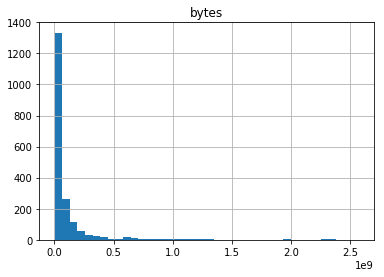

In [8]:
df_full.hist(column=col_name, bins=40)

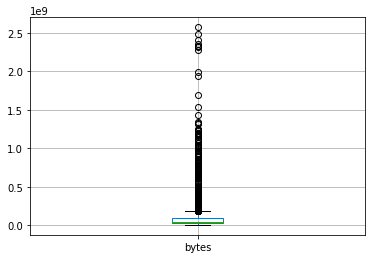

In [9]:
df_full.boxplot(column=col_name)

### Intermediate Thoughts
From the above distribution for our label variable, I am concerned with the lack of labels to predict values in the right tail. I'll see how the model does for the overall with basic least squares, and then explore reducing the data set to those value ranges that have adequate data. I'll then explore, or at least consider, where I can go from there if the reduced range perdictions look good.

### Study simpleCount Statistics

In [10]:
col_name = 'simpleCount'

In [11]:
df_full[col_name].describe()

count    1947.000000
mean        1.748331
std         7.759312
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       226.000000
Name: simpleCount, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22fe64b898>]],
      dtype=object)

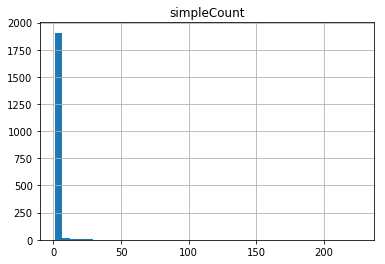

In [12]:
df_full.hist(column=col_name, bins=40)

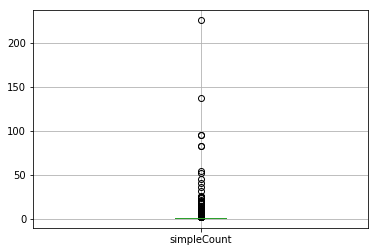

In [13]:
df_full.boxplot(column=col_name)

### Study tranCount Statistics

In [14]:
col_name = 'tranCount'

In [15]:
df_full[col_name].describe()

count      1947.000000
mean       7654.025167
std       21398.317884
min           0.000000
25%         480.000000
50%        1514.000000
75%        5149.000000
max      263611.000000
Name: tranCount, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22fe584a20>]],
      dtype=object)

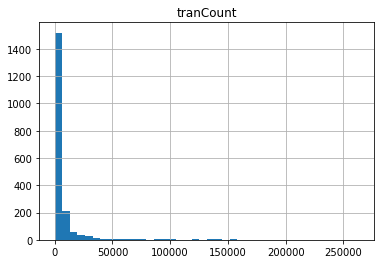

In [16]:
df_full.hist(column=col_name, bins=40)

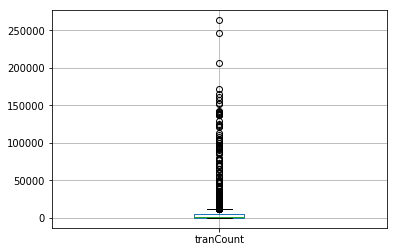

In [17]:
df_full.boxplot(column=col_name)

### Study secCount Statistics

In [18]:
col_name = 'secCount'

In [19]:
df_full[col_name].describe()

count     1947.000000
mean       756.775039
std       2540.876017
min          0.000000
25%         25.000000
50%        106.000000
75%        458.000000
max      40052.000000
Name: secCount, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22fe5099b0>]],
      dtype=object)

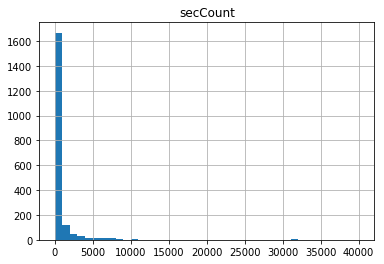

In [20]:
df_full.hist(column=col_name, bins=40)

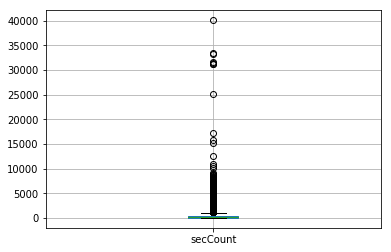

In [21]:
df_full.boxplot(column=col_name)

### Study lotCount Statistics

In [22]:
col_name = 'lotCount'

In [23]:
df_full[col_name].describe()

count     1947.000000
mean      2061.519774
std       6266.419388
min          0.000000
25%        114.500000
50%        452.000000
75%       1272.500000
max      95753.000000
Name: lotCount, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22fe4166d8>]],
      dtype=object)

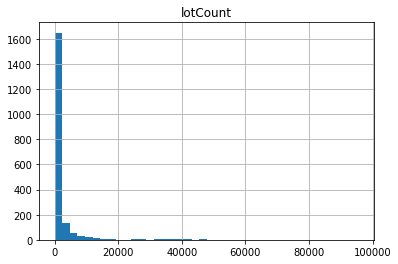

In [24]:
df_full.hist(column=col_name, bins=40)

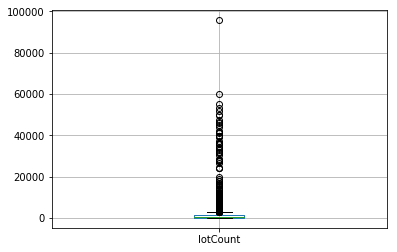

In [25]:
df_full.boxplot(column=col_name)

### Study amortCurveCount Statistics

In [26]:
col_name = 'amortCurveCount'

In [27]:
df_full[col_name].describe()

count     1947.000000
mean       220.339497
std       2712.249454
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      95245.000000
Name: amortCurveCount, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22fe3527b8>]],
      dtype=object)

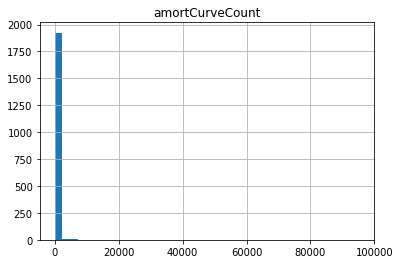

In [28]:
df_full.hist(column=col_name, bins=40)

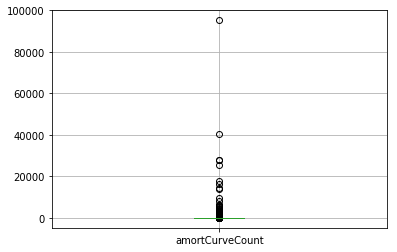

In [29]:
df_full.boxplot(column=col_name)

### Study extTranCount Statistics

In [30]:
col_name = 'extTranCount'

In [31]:
df_full[col_name].describe()

count      1947.000000
mean       8150.822291
std       28058.565950
min           0.000000
25%         344.000000
50%        1330.000000
75%        4325.500000
max      281125.000000
Name: extTranCount, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22fe27cd68>]],
      dtype=object)

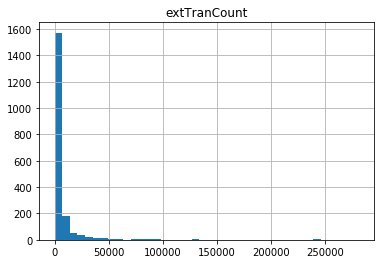

In [32]:
df_full.hist(column=col_name, bins=40)

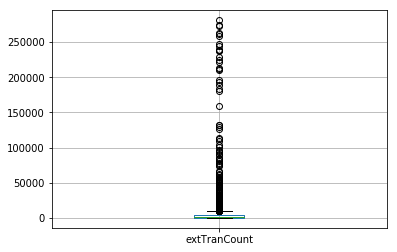

In [33]:
df_full.boxplot(column=col_name)

### Study extPosCount Statistics

In [34]:
col_name = 'extPosCount'

In [35]:
df_full[col_name].describe()

count    1947.000000
mean      178.815100
std       596.846306
min         0.000000
25%         0.000000
50%         7.000000
75%        87.000000
max      9307.000000
Name: extPosCount, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22fe1c33c8>]],
      dtype=object)

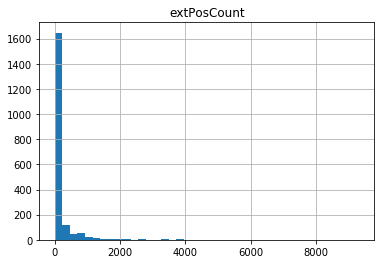

In [36]:
df_full.hist(column=col_name, bins=40)

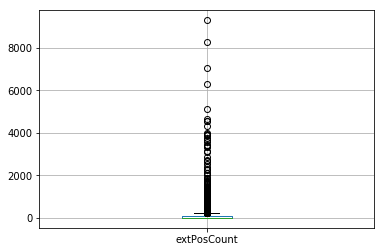

In [37]:
df_full.boxplot(column=col_name)

### Study basisCount Statistics

In [38]:
col_name = 'basisCount'

In [39]:
df_full[col_name].describe()

count    1947.000000
mean        1.994864
std         1.608039
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        12.000000
Name: basisCount, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22fe15bb00>]],
      dtype=object)

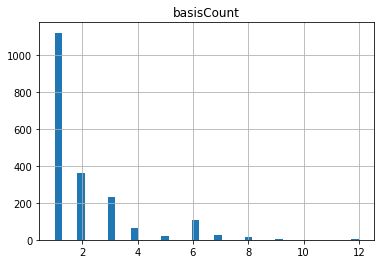

In [40]:
df_full.hist(column=col_name, bins=40)

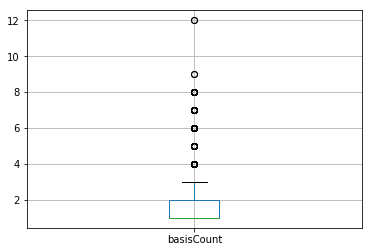

In [41]:
df_full.boxplot(column=col_name)

### Study hadMargin Statistics

In [410]:
col_name = 'hadMargin'

In [411]:
X = df_full.values
X = apply_one_hot_encoding_for_array_of_columns(X, [9])
df_full[col_name] = X[:,9]
df_full[col_name].describe()

count     1947.0
unique       2.0
top          1.0
freq      1889.0
Name: hadMargin, dtype: float64

In [412]:
df_full.head()

,bytes,simpleCount,tranCount,secCount,lotCount,amortCurveCount,extTranCount,extPosCount,basisCount,hadMargin
0,51028976,1,8990,1825,3413,0,7043,83,1,1
1,54706128,1,8566,1599,3276,0,8643,0,1,1
2,52176352,1,8455,1494,2949,0,8330,0,1,1
3,60859824,1,10992,1955,3541,0,9557,0,1,1
4,33574096,1,1112,57,76,0,984,8,2,1


## Explore Correlation Map

In [413]:
np.array(df_full.corr()).round(4).tolist()

[[1.0, 0.2893, 0.63, 0.3836, 0.5151, 0.2688, 0.6219, 0.452, 0.1483],
 [0.2893, 1.0, 0.1081, 0.0605, 0.0831, 0.1342, 0.072, 0.4957, 0.1872],
 [0.63, 0.1081, 1.0, 0.5695, 0.7742, 0.1203, 0.9027, 0.2568, -0.0189],
 [0.3836, 0.0605, 0.5695, 1.0, 0.7126, 0.0988, 0.3903, 0.251, 0.0202],
 [0.5151, 0.0831, 0.7742, 0.7126, 1.0, 0.1039, 0.7048, 0.2049, -0.0202],
 [0.2688, 0.1342, 0.1203, 0.0988, 0.1039, 1.0, 0.1038, 0.1853, 0.1575],
 [0.6219, 0.072, 0.9027, 0.3903, 0.7048, 0.1038, 1.0, 0.2422, -0.0415],
 [0.452, 0.4957, 0.2568, 0.251, 0.2049, 0.1853, 0.2422, 1.0, 0.221],
 [0.1483, 0.1872, -0.0189, 0.0202, -0.0202, 0.1575, -0.0415, 0.221, 1.0]]

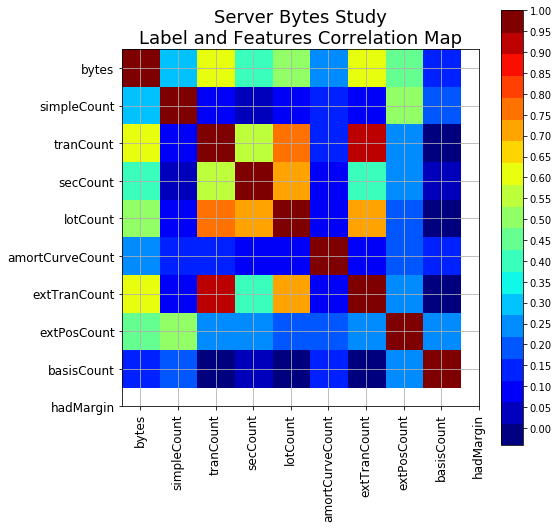

In [414]:
correlation_matrix(df_full, 'Server Bytes Study')

## Initial Attempt To Model Using Linear Least Squares

In [415]:
Values = df_full.values

X = Values[:,1:]
Y = Values[:,0]

print(len(X))

# Splitting the dataset into the Training set and Test set
nr.seed(731)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

1947
(1460, 9) (1460,) (487, 9) (487,)


In [416]:
scale_X = StandardScaler()
X_train = scale_X.fit_transform(X_train.astype('float64'))
X_test  = scale_X.transform(X_test.astype('float64'))

Mean Square Error      = 2.6940079976482292e+16
Root Mean Square Error = 164134335.15411177
Mean Absolute Error    = 62424641.24303834
Median Absolute Error  = 28172349.81405443
R^2                    = 0.5704275199464028
Adjusted R^2           = 0.5451585505314853


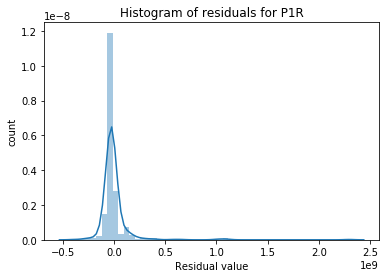

In [417]:
# algo = 'P1R', 'P2R', 'RFR', 'ABR', 'XGR', 'ANN'
algo = 'P1R'
settings = [] # (2,1.0,0.5)
mod = get_regression_model(algo, settings)

mod.fit(X_train, Y_train)
Y_pred = mod.predict(X_test)
                    
r2 = sklm.r2_score(Y_test, Y_pred)
rmse = math.sqrt(sklm.mean_squared_error(Y_test, Y_pred))

print_metrics(Y_test, Y_pred,28)
hist_resids(Y_test, Y_pred, algo)

del mod

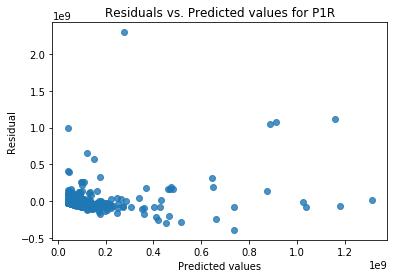

In [418]:
resid_plot(Y_test, Y_pred, algo)

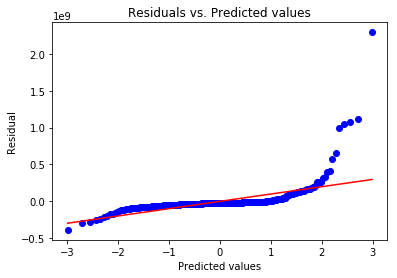

In [419]:
resid_qq(Y_test, Y_pred) #, 'Least Squares')

### Thoughts Up To This Point
As suspected, the higher values are reaking havoc on the modeling. I'll see how accurate we can be for the range of the labels that have adequate records. Also, I believe the data train/test is small enough that it is VERY sensitive to how it is split. Wildly different accuracies were found by starting the split with different random seeds. Some of the seeds produced good accuracies leading me to believe that more data would help.

## Second Attempt To Model Using Reduced Data Set

In [420]:
df_bytes_LT_3E8 = df_full[(df_full['bytes'] < 1e8)] #  & (df_full['bytes'] > 0.2e8)]
Values = df_bytes_LT_3E8.values

X = Values[:,1:]
Y = Values[:,0]
print(len(X))

# Splitting the dataset into the Training set and Test set
nr.seed(731)  #(731)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

1506
(1129, 9) (1129,) (377, 9) (377,)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22f902dda0>]],
      dtype=object)

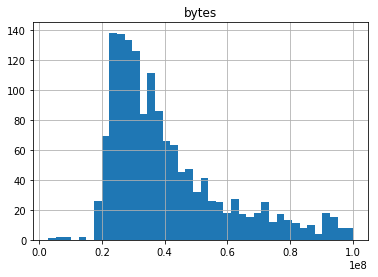

In [421]:
df_bytes_LT_3E8.hist(column='bytes',bins=40)

In [422]:
scale_X = StandardScaler()
X_train = scale_X.fit_transform(X_train.astype('float64'))
X_test  = scale_X.transform(X_test.astype('float64'))

Mean Square Error      = 169118961031590.72
Root Mean Square Error = 13004574.619401848
Mean Absolute Error    = 9224826.945677243
Median Absolute Error  = 7001415.072927758
R^2                    = 0.5179379447509151
Adjusted R^2           = 0.48064374563422374


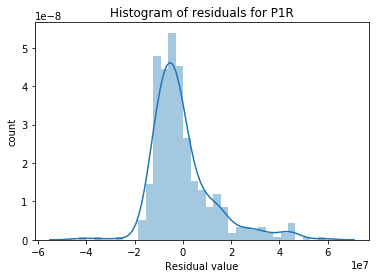

In [424]:
# algo = 'P1R', 'P2R', 'RFR', 'ABR', 'XGR', 'ANN'
algo = 'P1R'
settings = [] # (2,1.0,0.5)
mod = get_regression_model(algo, settings)

mod.fit(X_train, Y_train)
Y_pred = mod.predict(X_test)
                    
r2 = sklm.r2_score(Y_test, Y_pred)
rmse = math.sqrt(sklm.mean_squared_error(Y_test, Y_pred))

print_metrics(Y_test, Y_pred,28)
hist_resids(Y_test, Y_pred, algo)

del mod

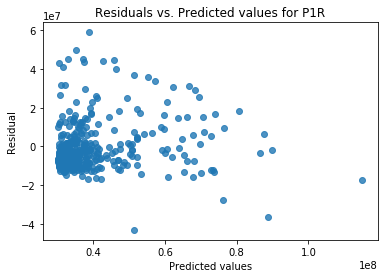

In [425]:
resid_plot(Y_test, Y_pred, algo)

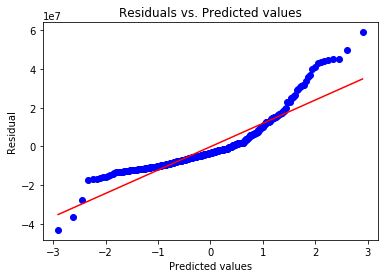

In [426]:
resid_qq(Y_test, Y_pred) #, 'Least Squares')

### Summary To This Point
I tried many ways to reduce the data set to see if that'd improve the results, but I believe the data train/test set was still small enough that it was sensitive to how it was split. I could still get wildly different accuracies depending on how the data was split, and this was found by starting the split with different random seeds. Again, some of the seeds produced usable accuracies, which further strengthened my belief that more data would help.

## Other Attempts Below
I tried many other models with various parameters while holding the random seed for the data split constant. 
The only models that did noteably better, SOME OF THE TIME, were ANNs. Their performance was very sensitive to the networks initial weights. I can't be sure, but I am fairly certain that this was due to the small size of the data set.

In [427]:
df_bytes_LT_3E8 = df_full # [df_full['bytes'] < 0.3e9]
Values = df_bytes_LT_3E8.values

X = Values[:,1:]
Y = Values[:,0]
print(len(X))

# Splitting the dataset into the Training set and Test set
nr.seed(731)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

1947
(1460, 9) (1460,) (487, 9) (487,)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22f8b91a58>]],
      dtype=object)

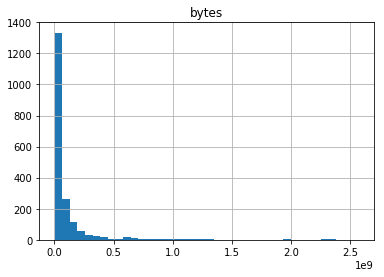

In [428]:
df_bytes_LT_3E8.hist(column='bytes',bins=40)

In [429]:
scale_X = StandardScaler()
X_train = scale_X.fit_transform(X_train.astype('float64'))
X_test  = scale_X.transform(X_test.astype('float64'))

Mean Square Error      = 2.5065049141313948e+16
Root Mean Square Error = 158319452.8202834
Mean Absolute Error    = 62052414.08125937
Median Absolute Error  = 25664220.46099256
R^2                    = 0.6003257847898396
Adjusted R^2           = 0.5768155368363007


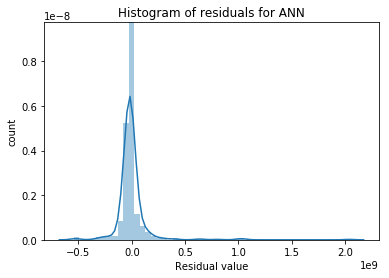

In [437]:
# algo = 'P1R', 'P2R', 'RFR', 'ABR', 'XGR', 'ANN'
algo = 'ANN'
settings = [9,9,9,1] #[9,18,1] # (2,1.0,0.5)
mod = get_regression_model(algo, settings)

mod.fit(X_train, Y_train)
Y_pred = mod.predict(X_test)
                    
r2 = sklm.r2_score(Y_test, Y_pred)
rmse = math.sqrt(sklm.mean_squared_error(Y_test, Y_pred))

print_metrics(Y_test, Y_pred,28)
hist_resids(Y_test, Y_pred, algo)

del mod

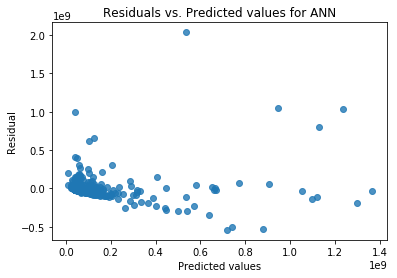

In [438]:
resid_plot(Y_test, Y_pred, algo)

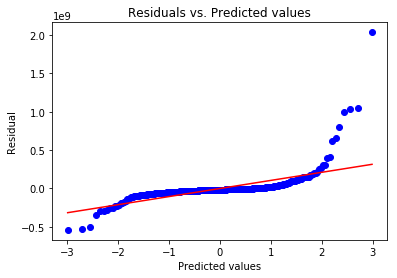

In [439]:
resid_qq(Y_test, Y_pred) #, 'Least Squares')

## Attempt Model Improvement Due To Feature Reduction

In [450]:
# ['bytes', 'simpleCount', 'tranCount', 'secCount', 'lotCount', 'amortCurveCount', 
#  'extTranCount', 'extPosCount', 'basisCount', 'hadMargin']

df_partial = df_full.drop(columns=['amortCurveCount'])
Values = df_partial.values

X = Values[:,1:]
Y = Values[:,0]
print(len(X))

# Splitting the dataset into the Training set and Test set
nr.seed(731)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

1947
(1460, 8) (1460,) (487, 8) (487,)


In [451]:
scale_X = StandardScaler()
X_train = scale_X.fit_transform(X_train.astype('float64'))
X_test  = scale_X.transform(X_test.astype('float64'))

Mean Square Error      = 2.78647318090235e+16
Root Mean Square Error = 166927324.93220964
Mean Absolute Error    = 63367912.39843165
Median Absolute Error  = 28501759.332194358
R^2                    = 0.555683503550105
Adjusted R^2           = 0.5295472390530523


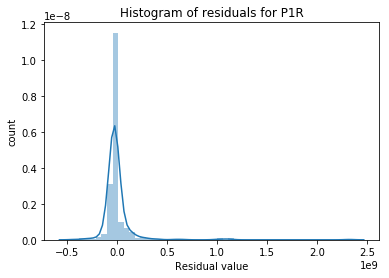

In [452]:
# algo = 'P1R', 'P2R', 'RFR', 'ABR', 'XGR', 'ANN'
algo = 'P1R'
settings = [] #[9,18,1] # (2,1.0,0.5)
mod = get_regression_model(algo, settings)

mod.fit(X_train, Y_train)
Y_pred = mod.predict(X_test)
                    
r2 = sklm.r2_score(Y_test, Y_pred)
rmse = math.sqrt(sklm.mean_squared_error(Y_test, Y_pred))

print_metrics(Y_test, Y_pred,28)
hist_resids(Y_test, Y_pred, algo)

del mod

### R^2 Values for Dropped Features
0. NONE 0.5704275199464028
1. simpleCount 0.555683503550105
2. tranCount 0.5654058426467733
3. secCount 0.568883736313414
4. lotCount 0.5707770930661065
5. amortCurveCount 0.5744509919896923
6. extTranCount 0.5421999328918832
7. extPosCount 0.5538676804318134
8. basisCount 0.5631116056374821
9. hadMargin 0.570417628893446

## Further Feature Reduction Exploration

In [508]:
# ['bytes', 'simpleCount', 'tranCount', 'secCount',
#  'extTranCount', 'extPosCount', 'basisCount', 'hadMargin']

# Optimal Set from Linear Least Squares Regression Exploration
df_partial = df_full.drop(columns=['amortCurveCount','lotCount'])
Values = df_partial.values

X = Values[:,1:]
Y = Values[:,0]
print(len(X))

# Splitting the dataset into the Training set and Test set
nr.seed(731)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

1947
(1460, 7) (1460,) (487, 7) (487,)


In [506]:
scale_X = StandardScaler()
X_train = scale_X.fit_transform(X_train.astype('float64'))
X_test  = scale_X.transform(X_test.astype('float64'))

Mean Square Error      = 2.664536913390204e+16
Root Mean Square Error = 163234093.05014086
Mean Absolute Error    = 62630128.759693734
Median Absolute Error  = 28681657.782865427
R^2                    = 0.5751268255036395
Adjusted R^2           = 0.550134285827383


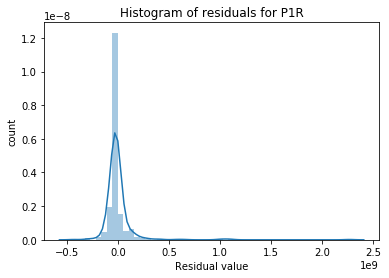

In [507]:
# algo = 'P1R', 'P2R', 'RFR', 'ABR', 'XGR', 'ANN'
algo = 'P1R'
settings = [] #[9,18,1] # (2,1.0,0.5)
mod = get_regression_model(algo, settings)

mod.fit(X_train, Y_train)
Y_pred = mod.predict(X_test)
                    
r2 = sklm.r2_score(Y_test, Y_pred)
rmse = math.sqrt(sklm.mean_squared_error(Y_test, Y_pred))

print_metrics(Y_test, Y_pred,28)
hist_resids(Y_test, Y_pred, algo)

del mod

### R^2 Values for Dropped Features (amortCurveCount + lotCount + )
0. amortCurveCount + lotCount 0.5751292392091478
1. simpleCount 0.5585142508245882
2. tranCount 0.5687554177771709
3. secCount 0.5687554177771709
6. extTranCount 0.5475248411225697
7. extPosCount 0.5548550585186063
8. basisCount 0.566982729717417
9. hadMargin 0.5751268255036395

## Attempt Best ANN Model

In [521]:
scale_X = StandardScaler()
X_train = scale_X.fit_transform(X_train.astype('float64'))
X_test  = scale_X.transform(X_test.astype('float64'))

In [584]:
# algo = 'P1R', 'P2R', 'RFR', 'ABR', 'XGR', 'ANN'
algo = 'ANN'
settings = [(9),1000000] # (2,1.0,0.5)

metric_min = 1e20
for cnt in range(100):
    mod = get_regression_model(algo, settings)

    mod.fit(X_train, Y_train)
    Y_pred = mod.predict(X_test)

    r2 = sklm.r2_score(Y_test, Y_pred)
    rmse = math.sqrt(sklm.mean_squared_error(Y_test, Y_pred))
    metric = rmse / r2
    if metric < metric_min:
        best_mod_9 = mod
        metric_min = metric
        r2_max = r2
        rmse_min = rmse

print('Best R^2 = {}, and best RMSE = {}'.format(r2_max, rmse_min))
# print_metrics(Y_test, Y_pred,28)
# hist_resids(Y_test, Y_pred, algo)

Best R^2 = 0.6252431951416217, and best RMSE = 153304879.64951816


## Preserve Max Model

1. best_mod_2 = Best R^2 = 0.6070665185463975, and best RMSE = 156978701.68109423
2. best_mod_3 = Best R^2 = 0.6174502882836681, and best RMSE = 154890632.87762967
3. best_mod_4 = Best R^2 = 0.620740497978032, and best RMSE = 154223107.6297061
4. best_mod_5 = Best R^2 = 0.6223043177442704, and best RMSE = 153904821.24375942
5. best_mod_6 = Best R^2 = 0.6226504412887568, and best RMSE = 153834285.23470458
6. best_mod_7 = Best R^2 = 0.6234726099197392, and best RMSE = 153666606.90000314
7. best_mod_8 = Best R^2 = 0.6254000715176242, and best RMSE = 153272788.92957327
8. **best_mod_9 = Best R^2 = 0.6344322828851741, and best RMSE = 151413686.3866099**
9. best_mod_10 = Best R^2 = 0.6313388943162557, and best RMSE = 152052958.768593
10. best_mod_11 = Best R^2 = 0.6252431951416217, and best RMSE = 153304879.64951816

Mean Square Error      = 2.2926104425182664e+16
Root Mean Square Error = 151413686.3866099
Mean Absolute Error    = 61686183.131715074
Median Absolute Error  = 26916617.256209746
R^2                    = 0.6344322828851741
Adjusted R^2           = 0.6129282995254784


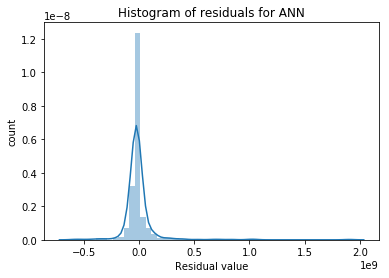

In [585]:
Y_pred = best_mod_9.predict(X_test)

print_metrics(Y_test, Y_pred,28)
hist_resids(Y_test, Y_pred, algo)

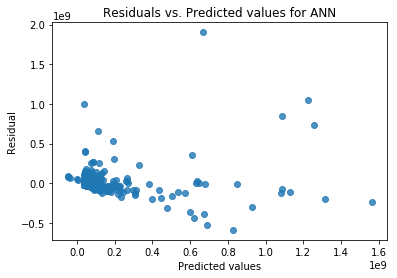

In [586]:
resid_plot(Y_test, Y_pred, algo)

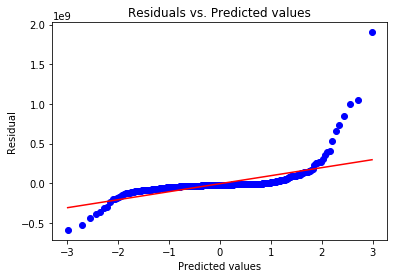

In [587]:
resid_qq(Y_test, Y_pred) #, 'Least Squares')

## Closing Comments
### Next Recommended Steps To Validate Such A Model, Which Can Provide Accurate Predictions
I would have liked to have gone further on this, and my conclusion is that a predictor can grow in accuracy over time with further work. Steps that I would have taken if I were actually working on this at Clearwater would be the following:
1. Seek to thoroughly understand each of the features.
2. Learn if other features could be collected that might increase the predictive accuracy of the modeling.
3. Seek to add to, or improve, the way that the data is collected.
     1. If the 'hadMargin' feature could be quanitified, it would help the modeling greatly I believe.
     2. If the initial models weren't indicating that I need more data, I would have sought to reduce the number of features through PCA analyses.
4. With additional data, I would do cross validation. The changing of my random seed for the train test splits indicated a lot of variation due to changes in the train and test sets. Thus, I knew this would reek havoc on  cross validation results. 
5. If I were to do this work for real, I would follow the steps above and seek more data, perform PCA and cross validation, and also seek a model that has the best balance between generalization and accuracy. Ongoing model improvment could also be done and automated as more data becomes available over time.

### If Model Becomes Accurate Enough for Production
In consideration of the above statements, if more data can be used right away, and the model accuracy provides better accuracy that current methods, I'd recommend putting the model into production immediately, and then seek to improve it over time.

Once the model is in place, I'd recommend automating the data collection, and the modeling steps practiced and suggested above. This way, the model can be updated IF another model provides more accurate predictions over the incumbent model. I'd recommend doing this automation in python and have a file based flag system that can alert the production system that a new model should be loaded and used.
     

## Further Investigations Following Further Thinking And Research
I had thought to do stratefied sampling. I have never had to use it before. The sklearn train_test_split functionality did not seem to match what I wanted to do, and you can see from the numbers below that I might need to be a bit more flexible. So I wrote my own, which was not hard. Here are the stratified groupings using 20 increments of the max value for bytes:
* From 0.0 to 128623684.8 there are 1587 values.
* From 128623684.8 to 257247369.6 there are 178 values.
* From 257247369.6 to 385871054.4 there are 59 values.
* From 385871054.4 to 514494739.2 there are 23 values.
* From 514494739.2 to 643118424.0 there are 23 values.
* From 643118424.0 to 771742108.8 there are 17 values.
* From 771742108.8 to 900365793.6 there are 11 values.
* From 900365793.6 to 1028989478.4 there are 12 values.
* From 1028989478.4 to 1157613163.2 there are 11 values.
* From 1157613163.2 to 1286236848.0 there are 10 values.
* From 1286236848.0 to 1414860532.8 there are 3 values.
* From 1414860532.8 to 1543484217.6 there are 2 values.
* From 1543484217.6 to 1672107902.3999999 there are 0 values.
* From 1672107902.3999999 to 1800731587.2 there are 1 values.
* From 1800731587.2 to 1929355272.0 there are 0 values.
* From 1929355272.0 to 2057978956.8 there are 2 values.
* From 2057978956.8 to 2186602641.6 there are 0 values.
* From 2186602641.6 to 2315226326.4 there are 2 values.
* From 2315226326.4 to 2443850011.2 there are 4 values.
* From 2443850011.2 to 2572473696.0 there are 2 values.

Due to the small number of points in some strati, I also felt it wiser to write my own routine so that I could provide additional logic according to my preference for how to best split the data. For example, if there are only 2 points in a strati, I want one from each in training and test. If there is only 1, use it only in the training set. If there are 3, and the split is 0.25, makes sure at least 1 appears in the test set, etc.

The results were not near the improvement I had hoped for, which leads me to believe that the hadMargin feature and the hard right skew are affecting the model accuracy significantly. Of course, it is hard to know at this point without further investigation, what is most needed to improve model accuracy. 

In [19]:
def strat_splitter(values, column, frac, increments=20.0):
    max_val = values[:,column].max()

    X_trn = np.empty((0,9), int)
    X_tst = np.empty((0,9), int)
    Y_trn = np.empty((0,), int)
    Y_tst = np.empty((0,), int)

    inc = max_val / increments

    for i in range(int(increments)):
        top = (i + 1) * inc
        bottom = i * inc

        values_temp = values[
                             (values[:,column] <= top) & 
                             (values[:,column] > bottom)]

        X = values_temp[:,1:]
        Y = values_temp[:,0]

        rows_in_strati = len(values_temp)

        if rows_in_strati == 1:
            test_frac = 0.0
            X_train, X_test, Y_train, Y_test = train_test_split(
                X, Y, test_size = test_frac)
            
            X_trn = np.append(X_trn, X_train, axis=0)
            X_tst = np.append(X_tst, X_test, axis=0)
            Y_trn = np.append(Y_trn, Y_train, axis=0)
            Y_tst = np.append(Y_tst, Y_test, axis=0)
            
        elif rows_in_strati >= 1:
            test_rows = math.ceil(rows_in_strati*frac)
            test_frac = test_rows / rows_in_strati
            
            X_train, X_test, Y_train, Y_test = train_test_split(
                X, Y, test_size = test_frac)
            
            X_trn = np.append(X_trn, X_train, axis=0)
            X_tst = np.append(X_tst, X_test, axis=0)
            Y_trn = np.append(Y_trn, Y_train, axis=0)
            Y_tst = np.append(Y_tst, Y_test, axis=0)

    return X_trn, X_tst, Y_trn, Y_tst

In [20]:
# ['bytes', 'simpleCount', 'tranCount', 'secCount',
#  'extTranCount', 'extPosCount', 'basisCount', 'hadMargin']

# Optimal Set from Linear Least Squares Regression Exploration
# df_partial = df_full.drop(columns=['amortCurveCount','lotCount'])
Values = df_full.values

X_train, X_test, Y_train, Y_test = strat_splitter(Values, 0, 0.25)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1454, 9) (1454,) (493, 9) (493,)


In [21]:
scale_X = StandardScaler()
X_train = scale_X.fit_transform(X_train.astype('float64'))
X_test  = scale_X.transform(X_test.astype('float64'))

Mean Square Error      = 3.3711383505593224e+16
Root Mean Square Error = 183606599.84214407
Mean Absolute Error    = 69113818.7058874
Median Absolute Error  = 26884374.336008467
R^2                    = 0.5777423876880289
Adjusted R^2           = 0.5725293307459057


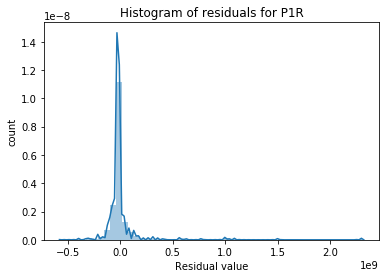

In [22]:
# algo = 'P1R', 'P2R', 'RFR', 'ABR', 'XGR', 'ANN'
algo = 'P1R'
settings = [] #[9,18,1] # (2,1.0,0.5)
mod = get_regression_model(algo, settings)

mod.fit(X_train, Y_train)
Y_pred = mod.predict(X_test)
                    
r2 = sklm.r2_score(Y_test, Y_pred)
rmse = math.sqrt(sklm.mean_squared_error(Y_test, Y_pred))

print_metrics(Y_test, Y_pred, 7)
hist_resids(Y_test, Y_pred, algo)

del mod

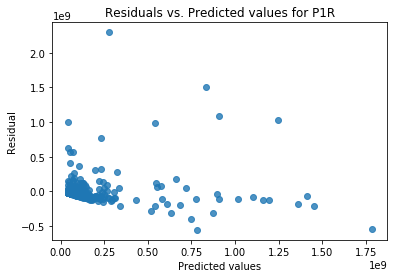

In [23]:
resid_plot(Y_test, Y_pred, algo)

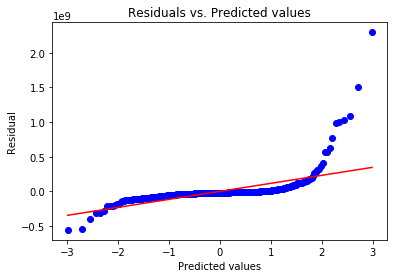

In [24]:
resid_qq(Y_test, Y_pred) #, 'Least Squares')

['bytes', 'simpleCount', 'tranCount', 'secCount', 'lotCount', 'amortCurveCount', 'extTranCount', 'extPosCount', 'basisCount', 'hadMargin']

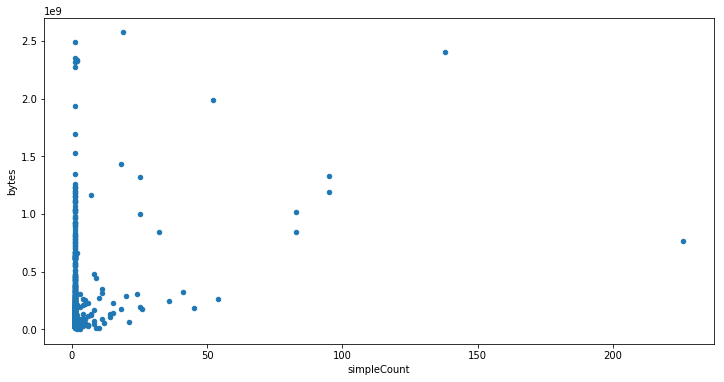

In [28]:
df_full.plot.scatter(x='simpleCount', y='bytes',figsize=(12,6))

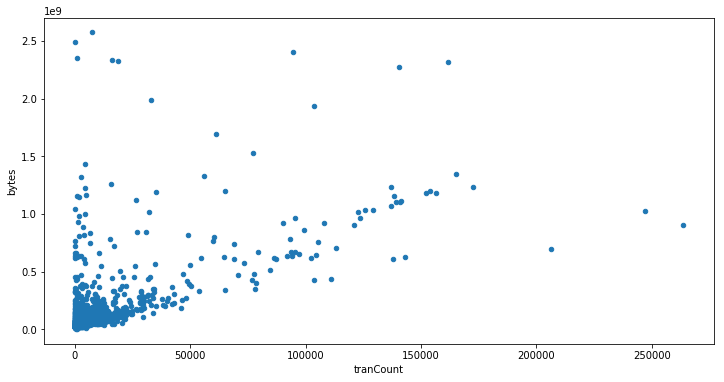

In [30]:
df_full.plot.scatter(x='tranCount', y='bytes',figsize=(12,6))

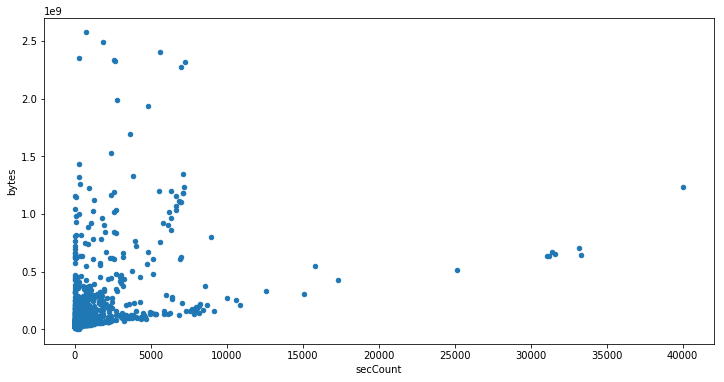

In [31]:
df_full.plot.scatter(x='secCount', y='bytes',figsize=(12,6))

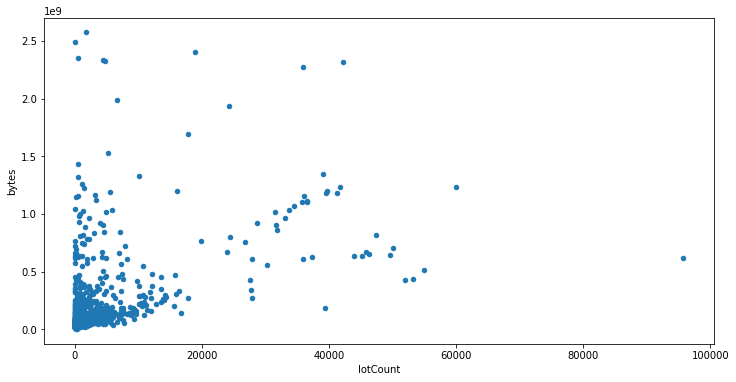

In [32]:
df_full.plot.scatter(x='lotCount', y='bytes',figsize=(12,6))

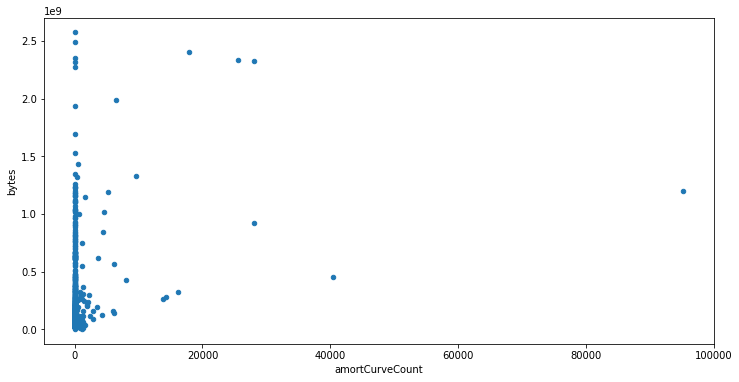

In [33]:
df_full.plot.scatter(x='amortCurveCount', y='bytes',figsize=(12,6))

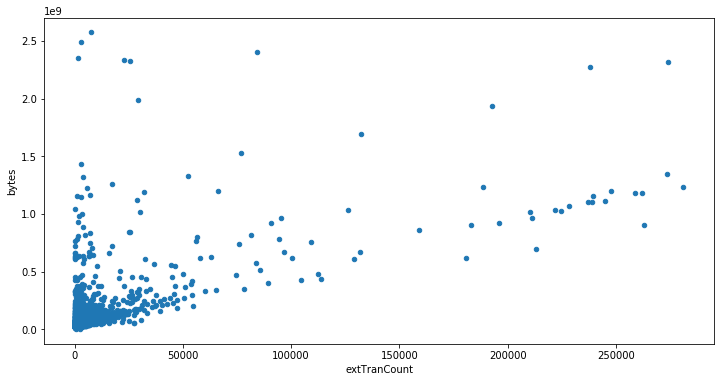

In [34]:
df_full.plot.scatter(x='extTranCount', y='bytes',figsize=(12,6))

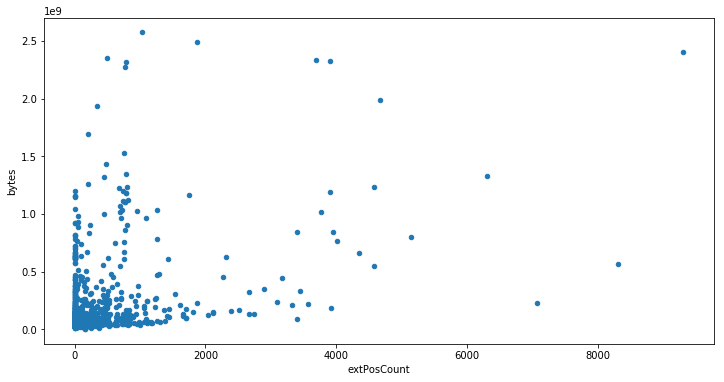

In [35]:
df_full.plot.scatter(x='extPosCount', y='bytes',figsize=(12,6))

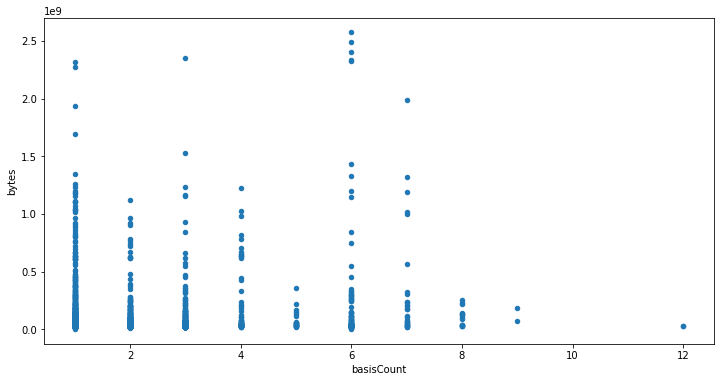

In [36]:
df_full.plot.scatter(x='basisCount', y='bytes',figsize=(12,6))